In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from neurobiases import EMSolver, ITSFASolver, TriangularModel
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
N = 40
M = 40
K = 1
D = 1000
n_datasets = 10

In [3]:
# get parameter dictionaries
tuning_kwargs, coupling_kwargs, noise_kwargs, stim_kwargs = \
    TriangularModel.generate_kwargs(N=N, M=M,
                                    tuning_sparsity=0.5,
                                    coupling_loc=-2,
                                    K=1)

In [4]:
tm = TriangularModel(
    model='linear',
    parameter_design='direct_response',
    tuning_kwargs=tuning_kwargs,
    coupling_kwargs=coupling_kwargs,
    noise_kwargs=noise_kwargs,
    stim_kwargs=stim_kwargs)

In [5]:
# true parameters
a = tm.a
b = tm.b
B = tm.B
L = tm.L[:, :-1].T
Psi = np.copy(tm.Psi)
log_Psi = np.log(Psi)

In [6]:
em_a = np.zeros((n_datasets, np.count_nonzero(a != 0)))
em_b = np.zeros((n_datasets, np.count_nonzero(b != 0)))

cem_a = np.copy(em_a)
cem_b = np.copy(em_b)

tc_a = np.copy(em_a)
tc_b = np.copy(em_b)

itsfa_a = np.copy(em_a)
itsfa_b = np.copy(em_b)

In [7]:
for dataset in range(n_datasets):
    print(dataset)
    X, Y, y = tm.generate_samples(n_samples=D)
    
    #em = EMSolver(X, Y, y, K=K,
    #              a_mask=a != 0, b_mask=b != 0, B_mask=B != 0,
    #              max_iter=1000, tol=1e-8)
    #em.fit_em(verbose=False)
    #em_a[dataset] = em.a.ravel()[a.ravel() != 0]
    #em_b[dataset] = em.b.ravel()[b.ravel() != 0]
    
    #copy = em.copy()
    #copy.apply_identifiability_constraint(constraint='coupling_norm')
    #cem_a[dataset] = copy.a.ravel()[a.ravel() != 0]
    #cem_b[dataset] = copy.b.ravel()[b.ravel() != 0]

    ols = LinearRegression(fit_intercept=False)
    ols.fit(np.concatenate((X[:, b.ravel() != 0], Y[:, a.ravel() != 0]), axis=1), y.ravel())
    tc_b[dataset], tc_a[dataset] = np.split(ols.coef_, [np.count_nonzero(b.ravel() != 0)])
    a_mask = (a != 0).ravel()
    b_mask = (b != 0).ravel()
    a_hat, b_hat, _ = ITSFASolver.itsfa(
        X=X, Y=Y, y=y, a_mask=a_mask, b_mask=b_mask, B_hat=B, B_hat_intercept=np.zeros(M), K=K
    )
    itsfa_a[dataset] = a_hat[a_mask]
    itsfa_b[dataset] = b_hat[b_mask]


0
1
2
3
4
5
6
7
8
9


In [8]:
b_nz = b.ravel()[b.ravel() != 0]
a_nz = a.ravel()[a.ravel() != 0]

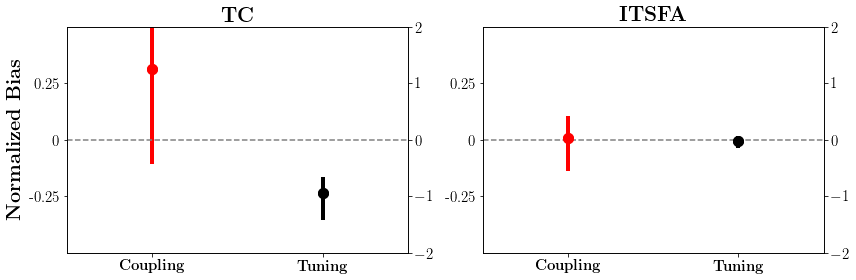

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

twins = []
for ax in axes:
    twins.append(ax.twinx())
    
#couplings = [tc_a, itsfa_a, em_a, cem_a]
#tunings = [tc_b, itsfa_b, em_b, cem_b]
couplings = [tc_a, itsfa_a]
tunings = [tc_b, itsfa_b]

for idx, ax in enumerate(axes):
    ax.boxplot(
        x=[np.mean(couplings[idx] - a_nz, axis=0) / np.abs(a_nz)],
        positions=[0],
        widths=0,
        boxprops={'linewidth' : 4, 'color': 'r'},
        medianprops={'marker' : '.', 'markersize' : 20, 'color' : 'r'},
        whiskerprops={'linewidth' : 4, 'color' : 'r'},
        showfliers=False
    )

for idx, tax in enumerate(twins):
    tax.boxplot(
        x=[np.mean(tunings[idx] - b_nz, axis=0) / np.abs(b_nz)],
        positions=[1],
        widths=0,
        boxprops={'linewidth' : 4, 'color': 'k'},
        medianprops={'marker' : '.', 'markersize' : 20, 'color' : 'k'},
        whiskerprops={'linewidth' : 4, 'color' : 'k'},
        showfliers=False
    )

for ax in axes:
    ax.set_ylim([-0.5, 0.5])
    ax.set_yticks([-0.25, 0, 0.25])
    ax.set_yticklabels(['-0.25', '0', '0.25'])
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([r'\textbf{Coupling}', r'\textbf{Tuning}'], fontsize=15)
    ax.tick_params(labelsize=15)
    
for tax in twins:
    tax.set_ylim([-2, 2])
    tax.set_yticks([-2, -1, 0, 1, 2])
    tax.tick_params(labelsize=15)
    
axes[0].set_ylabel(r'\textbf{Normalized Bias}', fontsize=20)

axes[0].set_title(r'\textbf{TC}', fontsize=21)
axes[1].set_title(r'\textbf{ITSFA}', fontsize=21)
#axes[2].set_title(r'\textbf{EM}', fontsize=21)
#axes[3].set_title(r'\textbf{cEM}', fontsize=21)
plt.tight_layout()